# CV recognition

#### Requirements

In [1]:
%pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached typing_extensions-4.5.0-py3-none-any.whl.metadata (8.5 kB)
Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.2
    Uninstalling typing_extensions-4.12.2:
      Successfully uninstalled typing_extensions-4.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ipython 8.24.0 requires typing-extensions>=4.6; python_version < "3.12", but you have typing-extensions 4.5.0 which is incompatible.
torchvision 0.18.0 requires torch==2.3.0, but you have torch 1.13.1 which is incompatible.
typeguard 4.3.0 requires typing-extensions>=4.10.0, but you have typing-extensions 4.5.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


#### Imports

In [3]:
import os
import pandas as pd
from kaggle.api.kaggle_api_extended import KaggleApi

## Dataset(s)

In [4]:
# Create the dataset folder if it does not exist
!mkdir -p dataset

In [5]:
# Download the dataset to the 'dataset' folder
!kaggle datasets download -d mehyarmlaweh/ner-annotated-cvs -p dataset

Dataset URL: https://www.kaggle.com/datasets/mehyarmlaweh/ner-annotated-cvs
License(s): MIT
100%|███████████████████████████████████████▉| 575M/576M [00:38<00:00, 16.8MB/s]
100%|████████████████████████████████████████| 576M/576M [00:38<00:00, 15.8MB/s]


In [6]:
# Unzip the .zip file into the 'dataset' folder
!unzip -o dataset/ner-annotated-cvs.zip -d dataset

Archive:  dataset/ner-annotated-cvs.zip
  inflating: dataset/ResumesJsonAnnotated/ResumesJsonAnnotated/cv (1)_annotated.json  
  inflating: dataset/ResumesJsonAnnotated/ResumesJsonAnnotated/cv (10)_annotated.json  
  inflating: dataset/ResumesJsonAnnotated/ResumesJsonAnnotated/cv (100)_annotated.json  
  inflating: dataset/ResumesJsonAnnotated/ResumesJsonAnnotated/cv (1000)_annotated.json  
  inflating: dataset/ResumesJsonAnnotated/ResumesJsonAnnotated/cv (1001)_annotated.json  
  inflating: dataset/ResumesJsonAnnotated/ResumesJsonAnnotated/cv (1002)_annotated.json  
  inflating: dataset/ResumesJsonAnnotated/ResumesJsonAnnotated/cv (1003)_annotated.json  
  inflating: dataset/ResumesJsonAnnotated/ResumesJsonAnnotated/cv (1004)_annotated.json  
  inflating: dataset/ResumesJsonAnnotated/ResumesJsonAnnotated/cv (1005)_annotated.json  
  inflating: dataset/ResumesJsonAnnotated/ResumesJsonAnnotated/cv (1006)_annotated.json  
  inflating: dataset/ResumesJsonAnnotated/ResumesJsonAnnotated/cv 

In [7]:
# RM the zip
!rm dataset/ner-annotated-cvs.zip

In [8]:
import os
import json
import pandas as pd

# Path to folder containing JSON files
folder_path = 'dataset/ResumesJsonAnnotated/ResumesJsonAnnotated'

# List to store extracted data
data = []
dataskill = []

# Read each JSON file in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        with open(file_path, 'r', encoding='utf-8') as file:
            json_data = json.load(file)
            text = json_data['text']
            annotations = json_data.get('annotations', [])
            skills = []
            for annotation in annotations:
                start, end, label = annotation
                skills.append(label.replace('SKILL: ', '').lower())
                dataskill.append({
                    'file_name': file_name,
                    'text': text,
                    'Skill': label.replace('SKILL: ', '').lower()
                })
            data.append({
                'file_name': file_name,
                'text': text,
                'Skills': skills
            })

# Convert to DataFrame
df = pd.DataFrame(data)
dfskill = pd.DataFrame(dataskill)

print(df.head())
df


                  file_name  \
0   cv (209)_annotated.json   
1  cv (3108)_annotated.json   
2  cv (4672)_annotated.json   
3  cv (5001)_annotated.json   
4  cv (4872)_annotated.json   

                                                text  \
0        HAMEED SATHIK M\n      HVAC Technical Co...   
1  MD EHTERAJ KHAN\n: 09073357048(M), 0842048419...   
2  INFORMATION TECHNOLOGY CONSULTANT\nHighlights\...   
3  TESSA MAERS\nPROFILE\nA strategic analyst whos...   
4  Titli Foundation \nSystem Developer, Jun 2020-...   

                                              Skills  
0  [building, problem solving, pumps, gmail, java...  
1  [reports, building, inventory, risk, safe, mai...  
2  [reports, reporting, inventory, windows xp, ma...  
3  [matlab, python, vba, business strategy, data ...  
4  [debugging, fixing, identification, detection,...  


,file_name,text,Skills
0,cv (209)_annotated.json,HAMEED SATHIK M\n HVAC Technical Co...,"[building, problem solving, pumps, gmail, java..."
1,cv (3108)_annotated.json,"MD EHTERAJ KHAN\n: 09073357048(M), 0842048419...","[reports, building, inventory, risk, safe, mai..."
2,cv (4672)_annotated.json,INFORMATION TECHNOLOGY CONSULTANT\nHighlights\...,"[reports, reporting, inventory, windows xp, ma..."
3,cv (5001)_annotated.json,TESSA MAERS\nPROFILE\nA strategic analyst whos...,"[matlab, python, vba, business strategy, data ..."
4,cv (4872)_annotated.json,"Titli Foundation \nSystem Developer, Jun 2020-...","[debugging, fixing, identification, detection,..."
...,...,...,...
5024,cv (4574)_annotated.json,ENGINEERING TEACHER\nProfessional Summary\nTo ...,"[reports, building, subject matter, ability, r..."
5025,cv (2508)_annotated.json,MOHAMMED FAIZ UR RAHMAN\nfaizrahman32@gmail.co...,"[gmail, knowledge, plumbing, vr, operations, p..."
5026,cv (2660)_annotated.json,SOFTWARE DEVELOPER MOHAMED AZARUDEEN T H\nth.a...,"[building, gmail, java, knowledge, asp, scorin..."
5027,cv (4981)_annotated.json,"Tata Sons \nAnalyst Support, Apr 2019 - Till d...","[visualisation, python, adobe, managing, deep ..."


In [9]:
print(len(dfskill['Skill'].unique()))
dfskill['Skill'].unique() # number of skills

12695


array(['building', 'problem solving', 'pumps', ..., 'construction plans',
       'parking lots', 'time management skills.'], dtype=object)

## Developper JS

In [10]:
df['prediction'] = 0 # Adding prediction column for label
df

,file_name,text,Skills,prediction
0,cv (209)_annotated.json,HAMEED SATHIK M\n HVAC Technical Co...,"[building, problem solving, pumps, gmail, java...",0
1,cv (3108)_annotated.json,"MD EHTERAJ KHAN\n: 09073357048(M), 0842048419...","[reports, building, inventory, risk, safe, mai...",0
2,cv (4672)_annotated.json,INFORMATION TECHNOLOGY CONSULTANT\nHighlights\...,"[reports, reporting, inventory, windows xp, ma...",0
3,cv (5001)_annotated.json,TESSA MAERS\nPROFILE\nA strategic analyst whos...,"[matlab, python, vba, business strategy, data ...",0
4,cv (4872)_annotated.json,"Titli Foundation \nSystem Developer, Jun 2020-...","[debugging, fixing, identification, detection,...",0
...,...,...,...,...
5024,cv (4574)_annotated.json,ENGINEERING TEACHER\nProfessional Summary\nTo ...,"[reports, building, subject matter, ability, r...",0
5025,cv (2508)_annotated.json,MOHAMMED FAIZ UR RAHMAN\nfaizrahman32@gmail.co...,"[gmail, knowledge, plumbing, vr, operations, p...",0
5026,cv (2660)_annotated.json,SOFTWARE DEVELOPER MOHAMED AZARUDEEN T H\nth.a...,"[building, gmail, java, knowledge, asp, scorin...",0
5027,cv (4981)_annotated.json,"Tata Sons \nAnalyst Support, Apr 2019 - Till d...","[visualisation, python, adobe, managing, deep ...",0


In [11]:
df_filtered = dfskill[dfskill['Skill'].str.contains(r'(js|javascript|java script)', case=False, na=False)]
df_filtered = df[df['file_name'].isin(df_filtered['file_name'])]
df['prediction'] = df['file_name'].isin(df_filtered['file_name']).astype(int) # Set prediction to 1 for file_names with javascript

test = df[df['prediction'] == 1]
print(len(test))
for skill in test['Skills']: # Show Interesting Resume Skills
    print(skill)

127
['reports', 'building', 'inventory', 'risk', 'safe', 'maintaining', 'gmail', 'java', 'knowledge', 'plumbing', 'capex', 'asp', 'contracts', 'strategies', 'operations', 'social networking', 'team management', 'performance', 'managing', 'technology', 'savings', 'operating systems', 'core java', 'facilities management', 'detection', 'service delivery', 'budgets', 'performance management', 'general administration', 'vendors', 'skills', 'compliance', 'opex', 'scripting language', 'projects', 'new processes', 'deploying', 'process', 'sql server', 'c', 'passport', 'business stakeholders', 'functions', 'hvac systems', 'developing', 'supervising', 'fire', 'trends', 'networking', 'voice', 'science', 'location', 'management', 'implementation', 'counseling', 'appreciation', 'reliable', 'interpersonal skills', 'ownership', 'delta', 'staffing', 'building services', 'ms access', 'levels', 'access', 'hvac', 'm', 'cctv', 'it skills', 'expansion', 'bms', 'processes', 'oracle', 'delivery', 'team', 'an

/tmp/ipykernel_78542/961083093.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_filtered = dfskill[dfskill['Skill'].str.contains(r'(js|javascript|java script)', case=False, na=False)]


In [12]:
df

,file_name,text,Skills,prediction
0,cv (209)_annotated.json,HAMEED SATHIK M\n HVAC Technical Co...,"[building, problem solving, pumps, gmail, java...",0
1,cv (3108)_annotated.json,"MD EHTERAJ KHAN\n: 09073357048(M), 0842048419...","[reports, building, inventory, risk, safe, mai...",1
2,cv (4672)_annotated.json,INFORMATION TECHNOLOGY CONSULTANT\nHighlights\...,"[reports, reporting, inventory, windows xp, ma...",0
3,cv (5001)_annotated.json,TESSA MAERS\nPROFILE\nA strategic analyst whos...,"[matlab, python, vba, business strategy, data ...",0
4,cv (4872)_annotated.json,"Titli Foundation \nSystem Developer, Jun 2020-...","[debugging, fixing, identification, detection,...",0
...,...,...,...,...
5024,cv (4574)_annotated.json,ENGINEERING TEACHER\nProfessional Summary\nTo ...,"[reports, building, subject matter, ability, r...",0
5025,cv (2508)_annotated.json,MOHAMMED FAIZ UR RAHMAN\nfaizrahman32@gmail.co...,"[gmail, knowledge, plumbing, vr, operations, p...",0
5026,cv (2660)_annotated.json,SOFTWARE DEVELOPER MOHAMED AZARUDEEN T H\nth.a...,"[building, gmail, java, knowledge, asp, scorin...",1
5027,cv (4981)_annotated.json,"Tata Sons \nAnalyst Support, Apr 2019 - Till d...","[visualisation, python, adobe, managing, deep ...",0


In [13]:
one = df[df['prediction'] == 1]
zero = df[df['prediction'] == 0]
zero = zero.sample(n=len(one), random_state=42)
dfModel = pd.concat([one, zero])
dfModel = dfModel.sample(frac=1, random_state=42).reset_index(drop=True) # Smaller dataset for better ratio between prediction = 0 or 1
dfModel

,file_name,text,Skills,prediction
0,cv (188)_annotated.json,Curricul...,"[reports, building, deployment, problem solvin...",0
1,cv (1398)_annotated.json,NADUKKARA HOUSE \n ...,"[reports, matlab, gmail, knowledge, arts, age,...",1
2,cv (893)_annotated.json,LOREN SHEVITZ\n345 W. FULLERTON #2101 PHONE: 7...,"[ability, python, java, arts, tcp/ip, ms offic...",1
3,cv (2097)_annotated.json,...,"[gmail, knowledge, marketing, resume, strength...",0
4,cv (1405)_annotated.json,\nCURRICULUM VITAE \nPERSONAL DETAILS \nNAM...,"[building, ability, prioritize, problem solvin...",1
...,...,...,...,...
249,cv (2249)_annotated.json,Deepak Saini\nE-mail: sainideepak142@gmail.com...,"[ability, gmail, java, knowledge, certificatio...",1
250,cv (4720)_annotated.json,CONSULTANT\nCareer Overview\nVidya is a Gradua...,"[reports, reporting, passion, ability, sales a...",1
251,cv (4927)_annotated.json,"ASI Technologies \nIntern, \nDec 2020 - Ongoin...","[building, deployment, python, web development...",1
252,cv (3703)_annotated.json,CURRICULAM-VITAE\nABDULLAH\nWard No. 30 Mohall...,"[reports, building, ability, gmail, knowledge,...",0


In [14]:
dfModel = dfskill[dfskill['file_name'].isin(dfModel['file_name'])]
print(len(dfModel['Skill'].unique()))
print(dfModel['Skill'].unique())
dfModel = dfModel.merge(df[['file_name', 'prediction']], on='file_name', how='left') # We separate the skills
dfModel

4985
['reports' 'building' 'inventory' ... 'multiple tasks' 'queues' 'ipad']


,file_name,text,Skill,prediction
0,cv (3108)_annotated.json,"MD EHTERAJ KHAN\n: 09073357048(M), 0842048419...",reports,1
1,cv (3108)_annotated.json,"MD EHTERAJ KHAN\n: 09073357048(M), 0842048419...",building,1
2,cv (3108)_annotated.json,"MD EHTERAJ KHAN\n: 09073357048(M), 0842048419...",inventory,1
3,cv (3108)_annotated.json,"MD EHTERAJ KHAN\n: 09073357048(M), 0842048419...",risk,1
4,cv (3108)_annotated.json,"MD EHTERAJ KHAN\n: 09073357048(M), 0842048419...",safe,1
...,...,...,...,...
32280,cv (2660)_annotated.json,SOFTWARE DEVELOPER MOHAMED AZARUDEEN T H\nth.a...,project,1
32281,cv (2660)_annotated.json,SOFTWARE DEVELOPER MOHAMED AZARUDEEN T H\nth.a...,personal,1
32282,cv (2660)_annotated.json,SOFTWARE DEVELOPER MOHAMED AZARUDEEN T H\nth.a...,applications,1
32283,cv (2660)_annotated.json,SOFTWARE DEVELOPER MOHAMED AZARUDEEN T H\nth.a...,airline,1


In [15]:
if 'text' in dfModel.columns:
    dfModel = dfModel.drop(columns=['text'])

df_pivot = dfModel.pivot_table(index='file_name', columns='Skill', aggfunc='size', fill_value=0).astype(bool)
df_pivot = df_pivot.rename(columns={'prediction': 'prediction_bool'})


df_prediction = dfModel[['file_name', 'prediction']].drop_duplicates().set_index('file_name')
dfModel = df_pivot.join(df_prediction)

dfModel = dfModel.reset_index()
dfModel
# We reverse our dataframe where each column is a skill

,file_name,.net,.net technologies,1 year experience,10 years experience,10 years of experience,12 months,12c,15 years of experience,2 years experience,...,xml,xml messages,xp,xpath,xquery,xsd,xslt,zend,zfs,prediction
0,cv (1021)_annotated.json,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,cv (1022)_annotated.json,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,1
2,cv (1034)_annotated.json,False,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,1
3,cv (1036)_annotated.json,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
4,cv (1059)_annotated.json,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
246,cv (887)_annotated.json,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
247,cv (893)_annotated.json,False,False,False,False,False,False,False,False,False,...,True,False,True,False,False,False,False,False,False,1
248,cv (934)_annotated.json,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,1
249,cv (935)_annotated.json,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,1


In [16]:
len(dfModel[dfModel['prediction'] == 1]) # We find our 127 CV prediction = 1

127

In [17]:
from sklearn.model_selection import train_test_split

dfModel = dfModel.drop('file_name', axis=1)
X = dfModel.drop('prediction', axis=1)
y = dfModel['prediction']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42) # Separate into training game and validation game

print(f'Training size : {X_train.shape[0]}')
print(f'Validation size : {X_val.shape[0]}')


Training size : 200
Validation size : 51


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_proba)
classification_rep = classification_report(y_val, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')
print('Classification Report:')
print(classification_rep) # We apply RandomForest on it

Accuracy: 0.9412
ROC AUC Score: 0.9938
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       0.93      0.96      0.94        26

    accuracy                           0.94        51
   macro avg       0.94      0.94      0.94        51
weighted avg       0.94      0.94      0.94        51



                    Model  Accuracy
0           Random Forest  0.941176
1       Gradient Boosting  0.960784
2     Logistic Regression  0.941176
3  Support Vector Machine  0.921569
4     K-Nearest Neighbors  0.784314
5           Decision Tree  0.941176
6             Naive Bayes  0.901961
7              Linear SVC  0.921569
8      XGBoost Classifier  0.941176
Model: Random Forest
Accuracy: 0.9412
ROC AUC Score: 0.9938461538461538
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94        25
           1       0.93      0.96      0.94        26

    accuracy                           0.94        51
   macro avg       0.94      0.94      0.94        51
weighted avg       0.94      0.94      0.94        51

------------------------------------------------------------
Model: Gradient Boosting
Accuracy: 0.9608
ROC AUC Score: 0.9861538461538462
Classification Report:
              precision    recall  f1-score   support

   

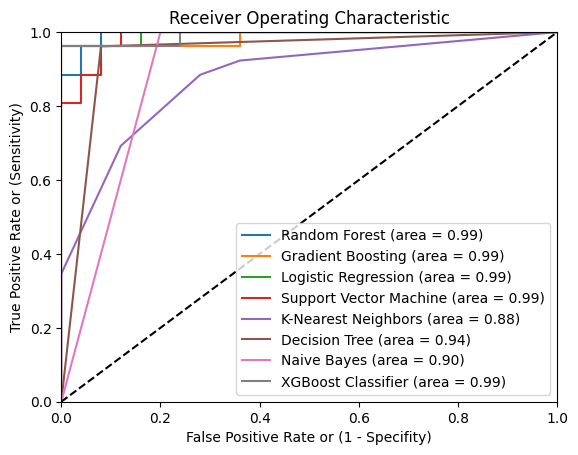

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import time
from sklearn.metrics import roc_curve, auc

# List of models to compare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42), # Concrete ML compatible
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42), # Concrete ML compatible
    "Support Vector Machine": SVC(probability=True, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(), # Concrete ML compatible
    "Decision Tree": DecisionTreeClassifier(random_state=42), # Concrete ML compatible
    "Naive Bayes": GaussianNB(),
    "Linear SVC": LinearSVC(random_state=42, max_iter=10000), # Concrete ML compatible
    "XGBoost Classifier": XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss') # Concrete ML compatible
}

# stock results
results = []

# Training and Validation
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    y_pred = model.predict(X_val)
    y_pred_proba = model.predict_proba(X_val)[:, 1] if hasattr(model, "predict_proba") else None
    
    accuracy = accuracy_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba) if y_pred_proba is not None else 'N/A'
    classification_rep = classification_report(y_val, y_pred)
    
    # Stock results
    results.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "ROC AUC": roc_auc,
        "Classification Report": classification_rep,
        "Execution time (sec)": training_time
    })

    # ROC curve
    if y_pred_proba is not None:
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{model_name} (area = {roc_auc:.2f})')

# DF pandas
results_df = pd.DataFrame(results)

# Accuracies
print(results_df[["Model", "Accuracy"]])

# Results
for index, row in results_df.iterrows():
    print(f'Model: {row["Model"]}')
    print(f'Accuracy: {row["Accuracy"]:.4f}')
    print(f'ROC AUC Score: {row["ROC AUC"]}')
    print('Classification Report:')
    print(row["Classification Report"])
    print('-' * 60)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [20]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

Fitting 3 folds for each of 216 candidates, totalling 648 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time

In [21]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

svc = SVC(random_state=42)

grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.2s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.2s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   0.3s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.3s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.3s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   0.2s
[CV] END ......................C=0.1, gamma=0.1, kernel=poly; total time=   0.2s
[CV] END .......................C=0.1, gamma=0.1, kernel=rbf; total time=   0.3s
[CV] END ......................C=0.1, gamma=0.1

In [22]:
# Define the parameter grid
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11]
}

knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_

print(f"Best parameters: {best_params}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END ......................................n_neighbors=3; total time=   0.1s
[CV] END ......................................n_neighbors=3; total time=   0.1s
[CV] END ......................................n_neighbors=3; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=5; total time=   0.1s
[CV] END ......................................n_neighbors=7; total time=   0.1s
[CV] END ......................................n_neighbors=7; total time=   0.1s
[CV] END ......................................n_neighbors=7; total time=   0.1s
[CV] END ......................................n_neighbors=9; total time=   0.1s
[CV] END ......................................n_neighbors=9; total time=   0.1s
[CV] END .....................................n_n

### With concret ML

In [23]:
import pandas as pd
from concrete.ml.sklearn.rf import RandomForestClassifier
from concrete.ml.sklearn.linear_model import LogisticRegression
from concrete.ml.sklearn.svm import LinearSVC
from concrete.ml.sklearn.neighbors import KNeighborsClassifier
from concrete.ml.sklearn.tree import DecisionTreeClassifier
from concrete.ml.sklearn.xgb import XGBClassifier
from sklearn.preprocessing import StandardScaler
import time

# Data normalization
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

if 'FHE Accuracy' not in results_df.columns: # Adds FHE Accuracy column
    results_df['FHE Accuracy'] = None

if 'FHE Execution time (sec)' not in results_df.columns: # Adds FHE Accuracy column
    results_df['FHE Execution time (sec)'] = None

# List of models to compare
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42), # Concrete ML
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42), # Concrete ML
    "K-Nearest Neighbors": KNeighborsClassifier(), # Concrete ML
    "Decision Tree": DecisionTreeClassifier(random_state=42), # Concrete ML
    "Linear SVC": LinearSVC(random_state=42, max_iter=10000), # Concrete ML
    "XGBoost Classifier": XGBClassifier(random_state=42, use_label_encoder=False) # Concrete ML # , eval_metric='logloss'
}

# Training and Validation
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    y_pred = model.predict(X_val)
    if hasattr(model, "predict_proba") and model_name != "K-Nearest Neighbors":
        y_pred_proba = model.predict_proba(X_val)[:, 1]
    
    accuracy = accuracy_score(y_val, y_pred)
    
    # Stock result
    results_df.loc[results_df['Model'] == model_name, 'FHE Accuracy'] = accuracy
    results_df.loc[results_df['Model'] == model_name, 'FHE Execution time (sec)'] = training_time

# Results
results_df[['Model','Accuracy','Execution time (sec)','FHE Accuracy','FHE Execution time (sec)']]

/home/sandro/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


,Model,Accuracy,Execution time (sec),FHE Accuracy,FHE Execution time (sec)
0,Random Forest,0.941176,0.102731,0.960784,8.268291
1,Gradient Boosting,0.960784,0.737141,None,None
2,Logistic Regression,0.941176,0.048429,0.901961,0.195513
3,Support Vector Machine,0.921569,0.307432,None,None
4,K-Nearest Neighbors,0.784314,0.012994,0.54902,0.27751
5,Decision Tree,0.941176,0.043417,0.941176,7.140473
6,Naive Bayes,0.901961,0.025934,None,None
7,Linear SVC,0.921569,0.045847,0.901961,8.201675
8,XGBoost Classifier,0.941176,1.303365,0.960784,7.055762


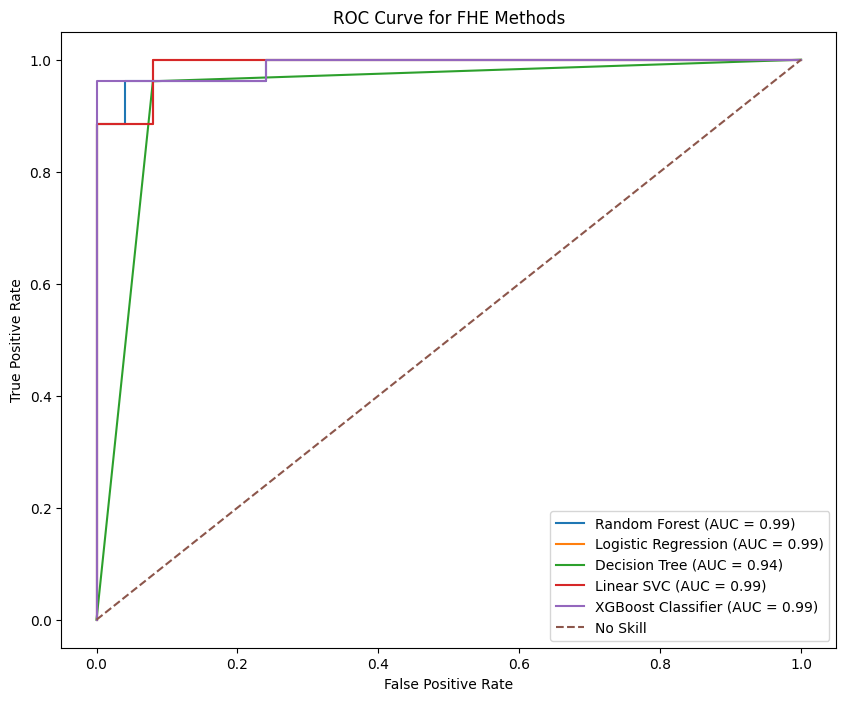

In [24]:
plt.figure(figsize=(10, 8))

# Plot ROC Curve for each FHE model
for model_name, model in models.items():
    if hasattr(model, "predict_proba") and model_name != "K-Nearest Neighbors":
        y_pred_proba = model.predict_proba(X_val)[:, 1]
        
        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_val, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        
        # Plot
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot no-skill classifier
plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')

# Customize the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for FHE Methods')
plt.legend(loc="lower right")
plt.show()

## Modele Lineaire 

#### Architecture

#### Training

#### Test

## Decision Tree

#### Architecture

#### Training

#### Test